# Лабораторная работа №5
### Кривошейкин Сергей Р3214

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image

##### Исследуя файл Subject00_1.edf, получаем:

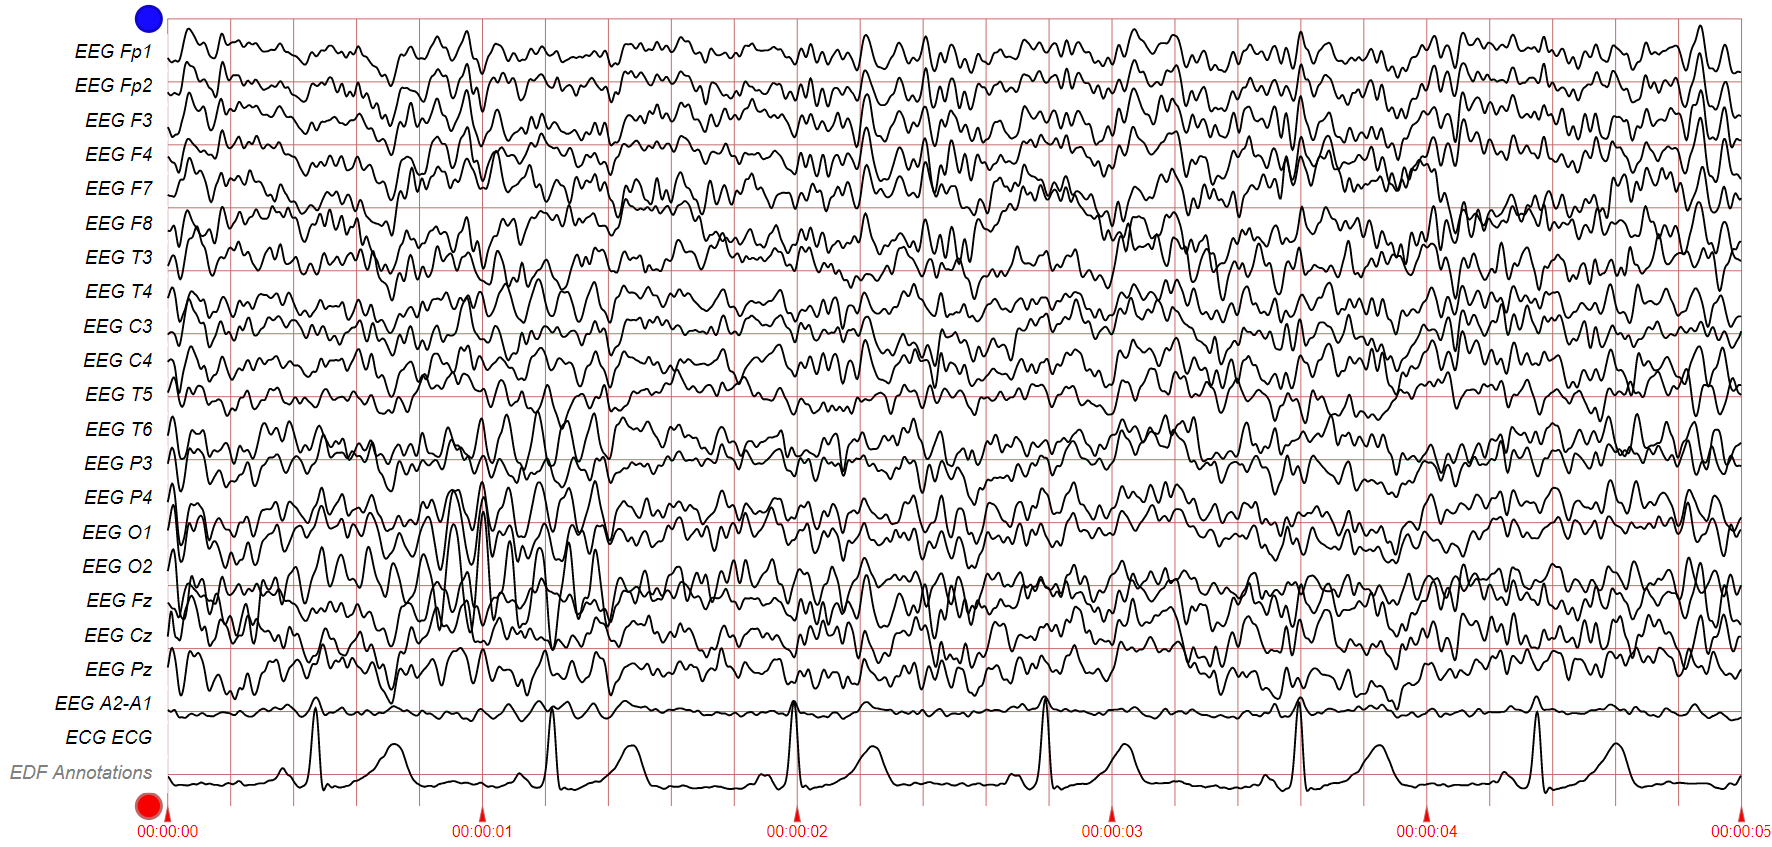

In [2]:
Image(filename = "lab5_img/e1.png", width=800, height=800)

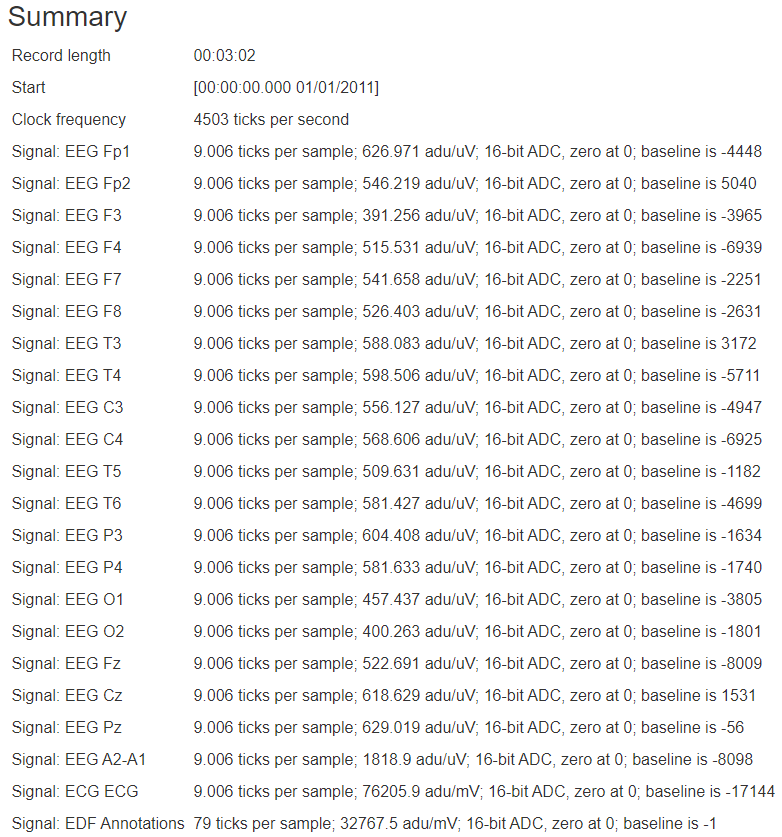

In [3]:
Image(filename = "lab5_img/t1.png", width=500, height=500)

##### Исследуя файл Subject00_2.edf, получаем:

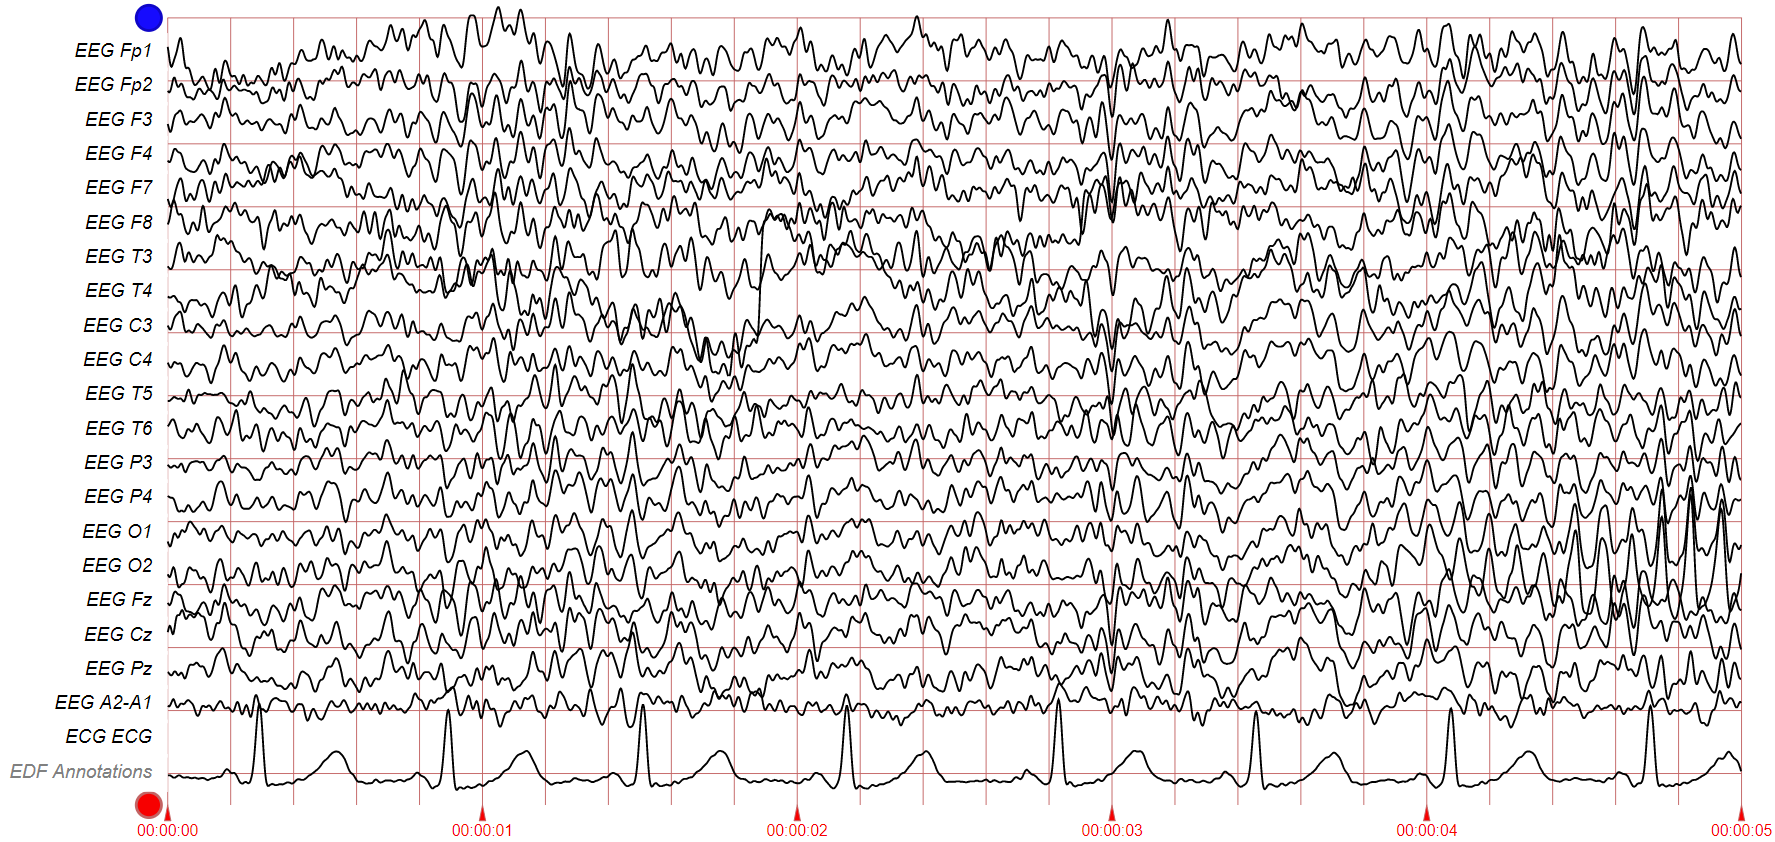

In [4]:
Image(filename = "lab5_img/e2.png", width=800, height=800)

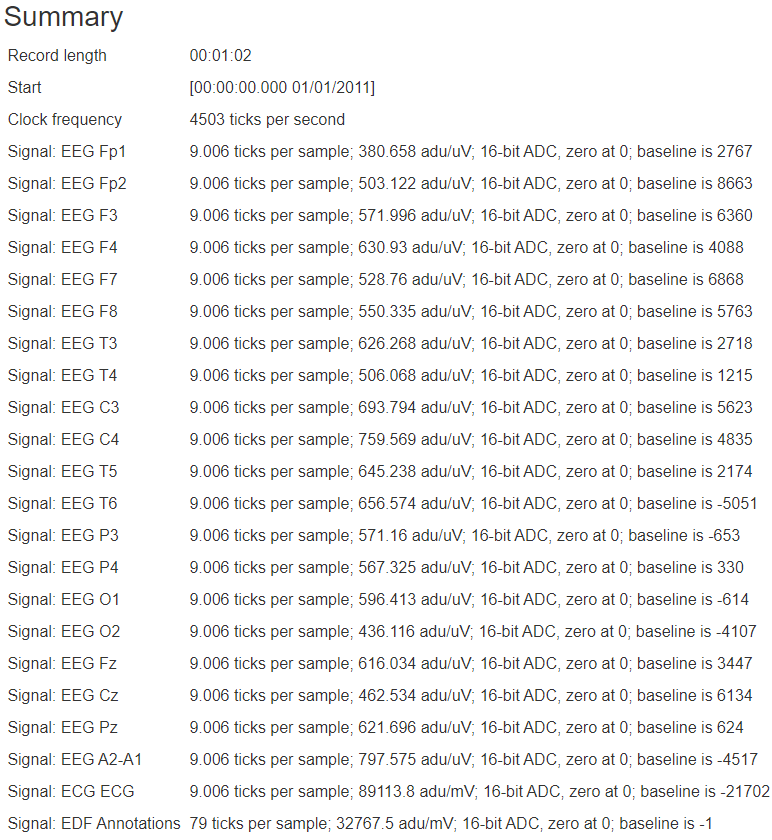

In [5]:
Image(filename = "lab5_img/t2.png", width=500, height=500)

Файлы данных с ЭЭГ предоставляются в формате EDF. Каждая папка содержит по два файла записи на каждый предмет:
- с постфиксом " _1 " - запись фоновой ЭЭГ испытуемого перед арифметическим заданием
- с постфиксом " _2 " - запись ЭЭГ во время выполнения  арифметического задания

### Выявить все альфа-волны

In [6]:
from pyedflib import highlevel
def read_edf(path):
    return highlevel.read_edf(path)

sample_1, sample_headers_1, header_1 = read_edf('Subject00_1.edf')
sample_2, sample_headers_2, header_2 = read_edf('Subject00_2.edf')

In [7]:
sample_headers_1[0]

{'label': 'EEG Fp1',
 'dimension': 'uV',
 'sample_rate': 500,
 'physical_max': 59.35658,
 'physical_min': -45.1698,
 'digital_max': 32767,
 'digital_min': -32768,
 'prefilter': 'HP:0.500000Hz LP:45.000000Hz RF:50Hz',
 'transducer': ''}

Доминирующий ритм ЭЭГ в затылочно-теменной области => требуется рассматривать O и P датчики

In [8]:
new_sample_1 = []
new_sample_headers_1 = []
new_sample_2 = []
new_sample_headers_2 = []
for s1, lab1, s2, lab2 in zip(sample_1, sample_headers_1, sample_2, sample_headers_2):
    if 'EEG O' in lab1['label'] or 'EEG P' in lab1['label']:
        new_sample_1.append(s1)
        new_sample_headers_1.append(lab1)    
    if 'EEG O' in lab2['label'] or 'EEG P' in lab2['label']:
        new_sample_2.append(s2)
        new_sample_headers_2.append(lab2)
sample_1 = np.array(new_sample_1)
sample_headers_1 = new_sample_headers_1
sample_2 = np.array(new_sample_2)
sample_headers_2 = new_sample_headers_2

#### Преобразование Фурье

In [9]:
def get_freq_and_four(sample, per_seq = 250):
    n = len(sample)
    amplitude = abs(sp.fft.fft(sample))[:n//2]
    time = [i/per_seq for i in range(n//2)]
    freq = sp.fft.fftfreq(n, d=1/per_seq)[:n//2]
    return time, freq, amplitude


def fourier_transform(sample, per_seq = 250):
    f_time = []
    f_freq = []
    f_signals = []
    for s in sample:
        time, freq, amplitude = get_freq_and_four(s, per_seq)
        f_time.append(time)
        f_freq.append(freq)
        f_signals.append(amplitude)
    return np.array(f_time), np.array(f_freq), np.array(f_signals)

In [10]:
time_1, freq_1, amplitude_1 = fourier_transform(sample_1, 500)
time_2, freq_2, amplitude_2 = fourier_transform(sample_2, 500)

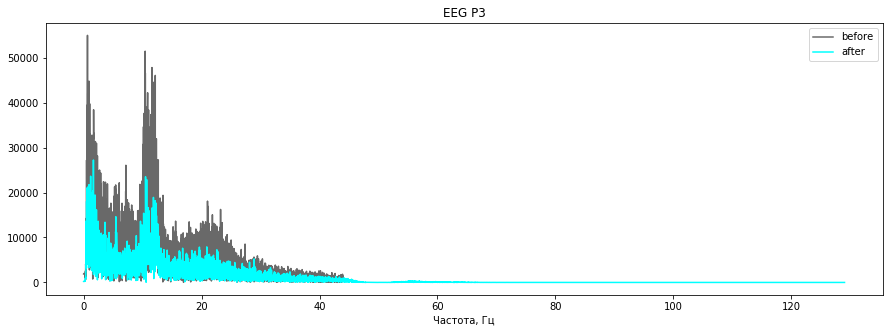

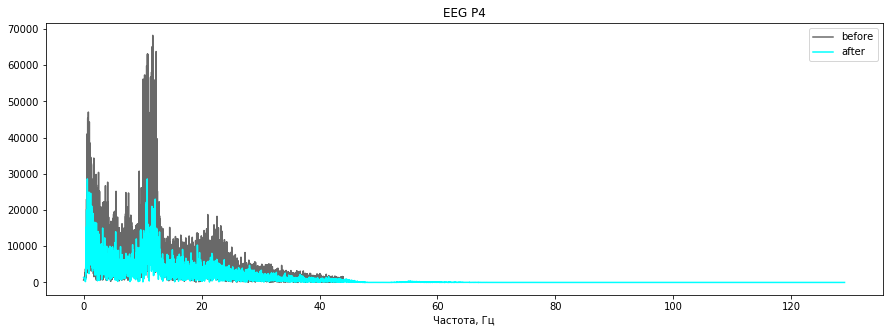

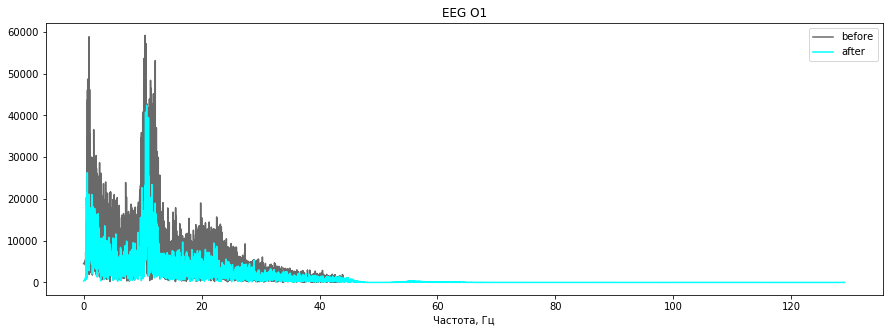

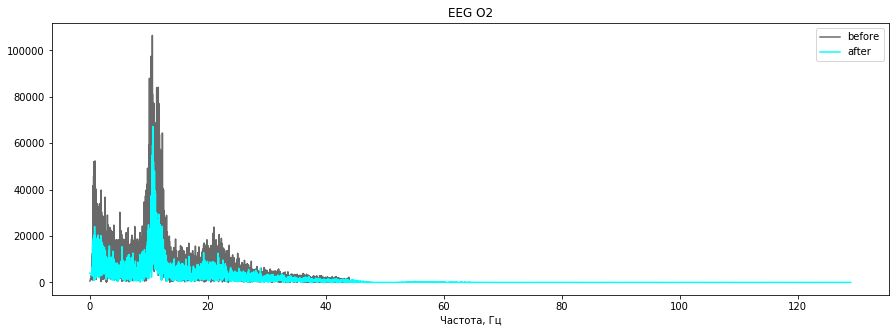

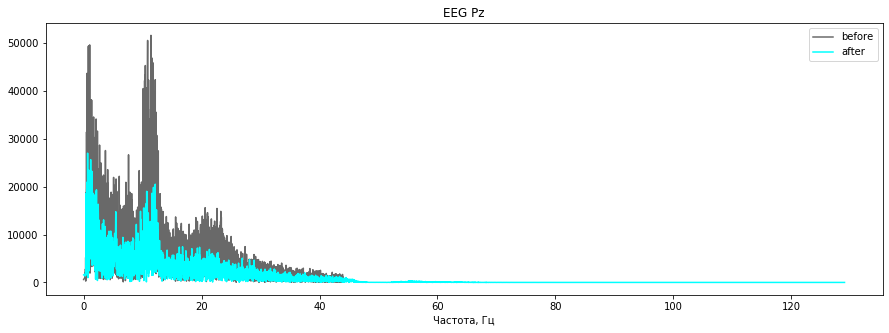

In [11]:
def draw_signals(freq, f_signals, label = '', color = '', first_n = 8000):
    freq = freq[:first_n]
    f_signals = f_signals[:first_n]
    plt.plot(freq, f_signals, color, label = label)

def draw_for_sample(freqs_before, f_samples_before, freqs_after, f_samples_after, sample_headers, first_n = 8000):
    for sample_b, freq_b, sample_a, freq_a, head in zip(f_samples_before, freqs_before, f_samples_after, freqs_after, sample_headers):
        plt.figure(figsize=(15, 5))
        if len(sample_a)>0:
            draw_signals(freq_b, sample_b, 'before', 'dimgrey', first_n)
        if len(sample_b)>0:
            draw_signals(freq_a, sample_a, 'after', 'cyan', first_n)
        plt.xlabel('Частота, Гц')
        plt.title(head['label'])
        plt.legend(ncol=1)
        plt.show()

draw_for_sample(freq_1, amplitude_1, freq_2, amplitude_2, sample_headers_1)

Альфа-ритм - ритм в полосе частот от 8 до 14 Гц

In [12]:
def cut(freq, f_signals, left_freq, right_freq, left_sig, right_sig):
    take_array = (left_freq < freq) & (freq < right_freq) & (left_sig < f_signals) & (f_signals < right_sig)
    f_signals = f_signals[take_array]
    freq = freq[take_array]
    return freq, f_signals

def manage_all(freq, f_signals, left_freq, right_freq, left_sig, right_sig):
    new_freqs = []
    new_sigs = []
    for fr, sig in zip(freq, f_signals):
        new_fr, new_s =  cut(fr, sig, left_freq, right_freq, left_sig, right_sig)
        new_freqs.append(new_fr)
        new_sigs.append(new_s)
    return np.array(new_freqs), np.array(new_sigs)

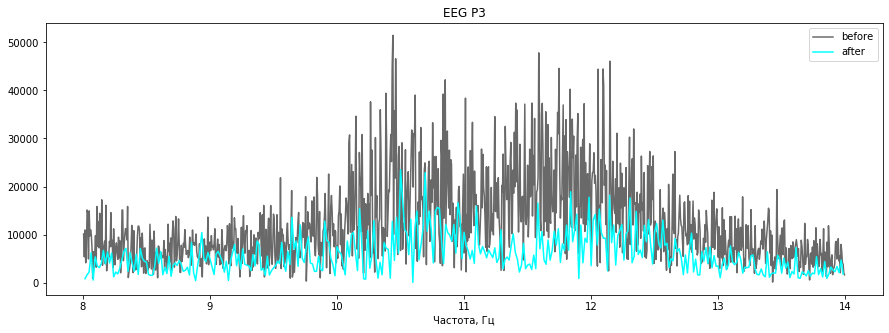

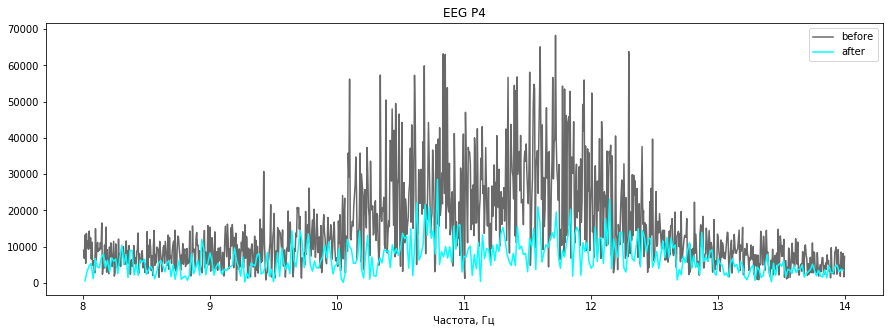

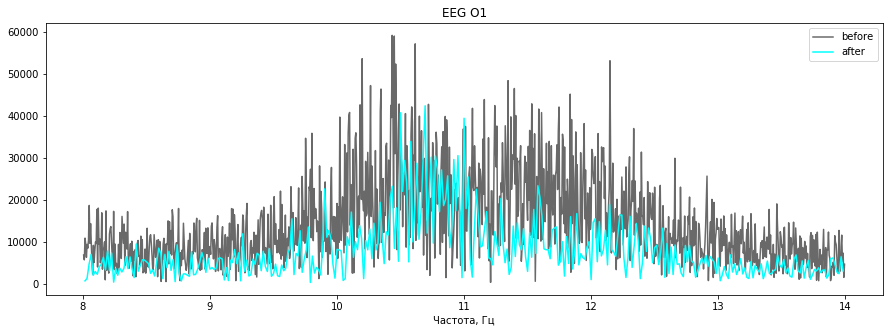

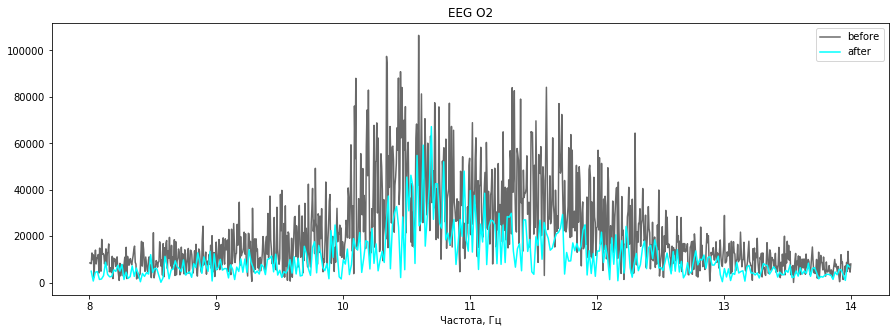

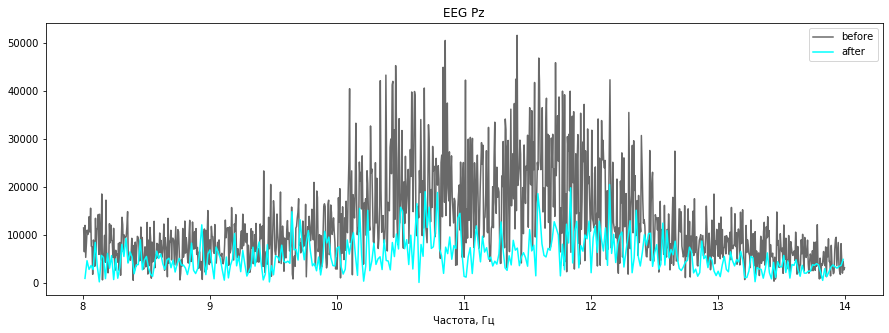

In [13]:
freq_1_cutted, amplitude_1_cutted = manage_all(freq_1, amplitude_1, 8, 14, 0, float('+inf'))
freq_2_cutted, amplitude_2_cutted = manage_all(freq_2, amplitude_2, 8, 14, 0, float('+inf'))
draw_for_sample(freq_1_cutted, amplitude_1_cutted, freq_2_cutted, amplitude_2_cutted, sample_headers_1)

Альфа-ритм связан с расслабленным состоянием бодрствования, покоя. Альфа-волны возникают тогда, когда мы закрываем глаза и начинаем расслабляться. Депрессия альфа-ритма (недостаток альфа-волн) возникает тогда, когда человек открывает глаза или думает над задачей, которая требует определённых зрительных представлений. При повышении функциональной активности мозга амплитуда альфа-ритма уменьшается вплоть до полного исчезновения.

### Спектральный анализ

In [14]:
import scipy.signal as sig
def spectral_analysis(signals):
    new_signals = signals - np.mean(signals)
    
    wn = sig.kaiser(len(new_signals), beta=7)
    new_signals = new_signals * wn
    
    N=100
    # Forward FFT
    xFFT = sp.fft.fftshift(sp.fft.fft(new_signals, N))
    # Magnitude spectrum
    xA = np.abs(xFFT)
    # Phase spectrum
    xF = np.angle(xFFT)
    return xA, xF

EEG P3


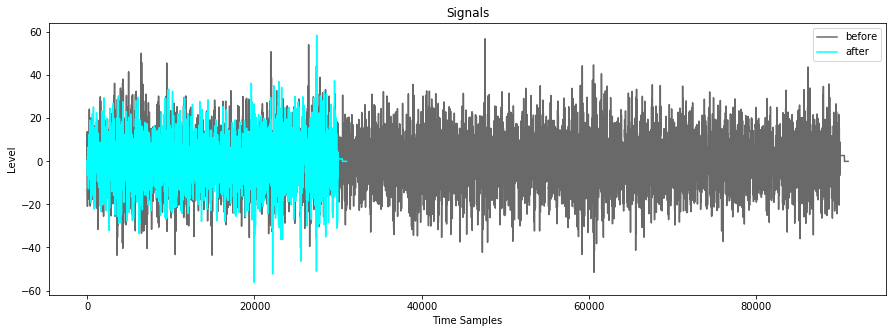

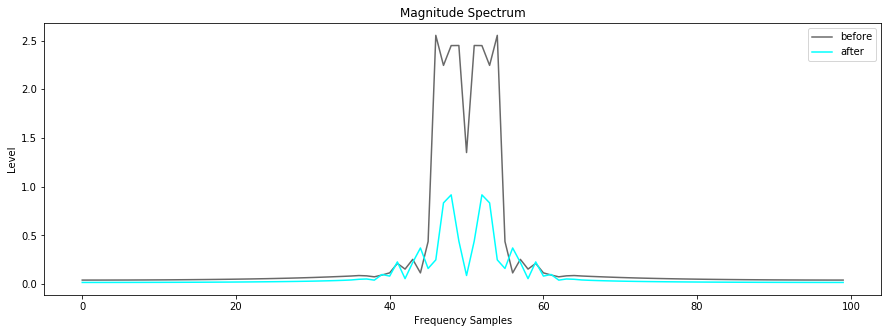

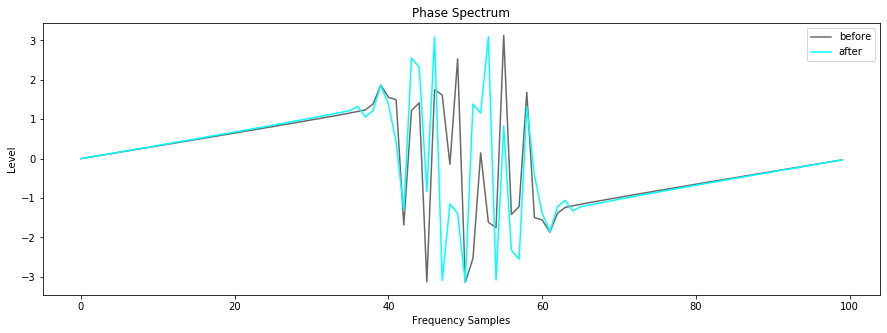

EEG P4


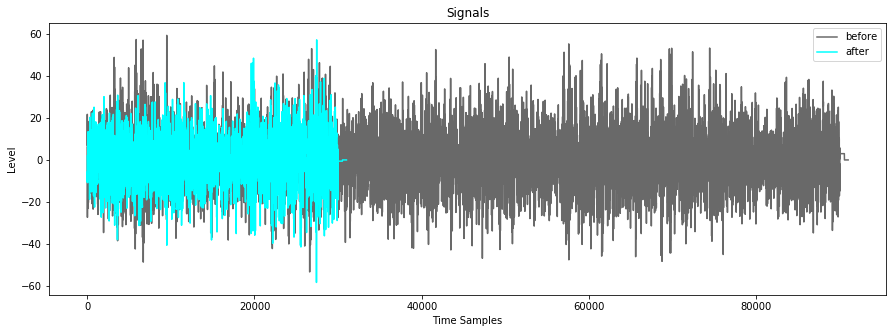

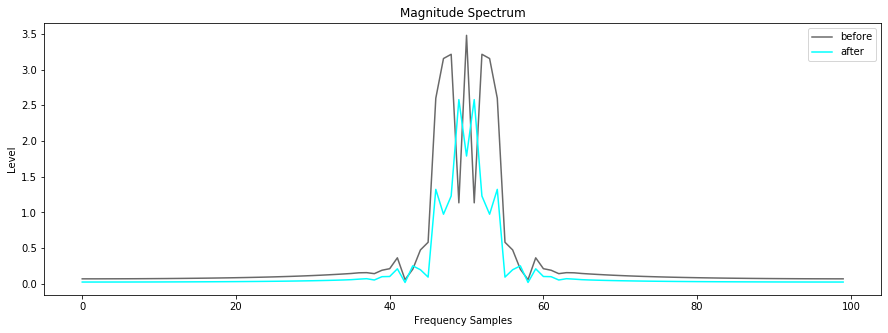

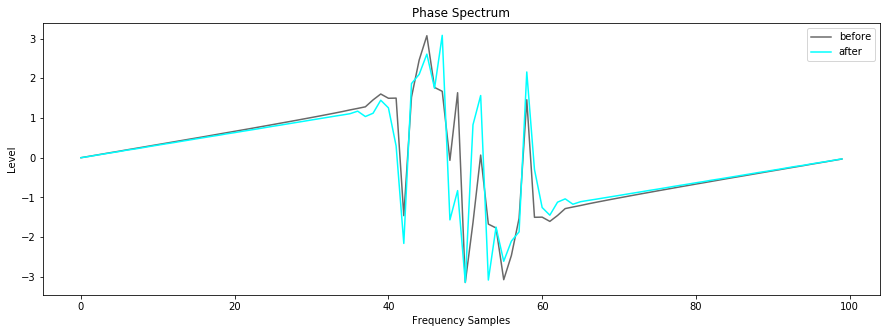

EEG O1


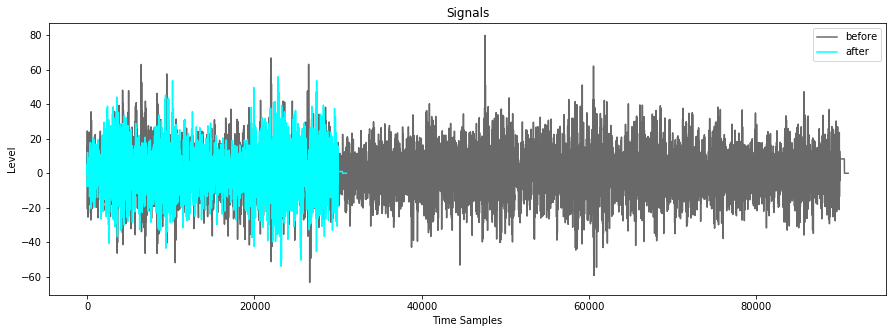

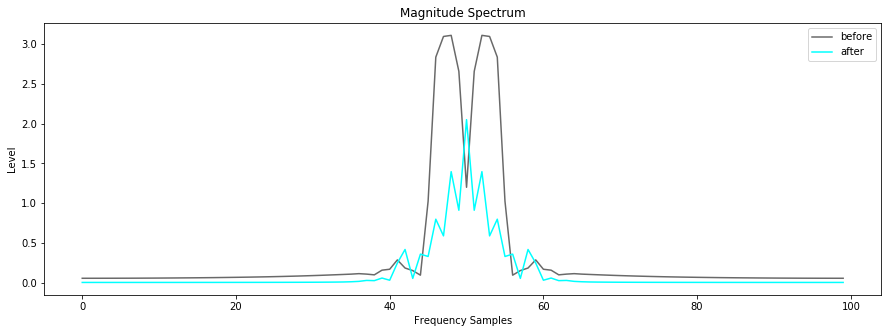

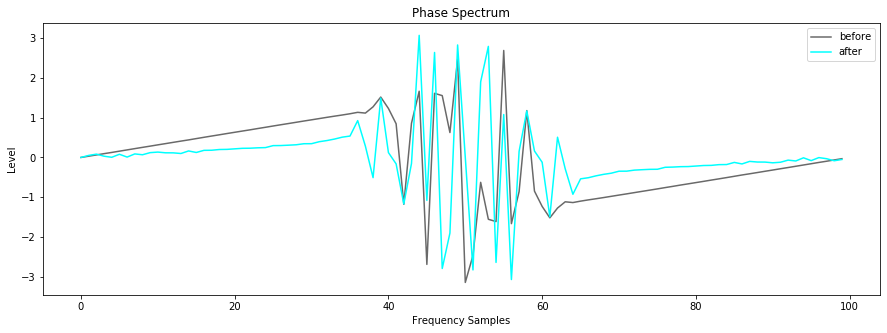

EEG O2


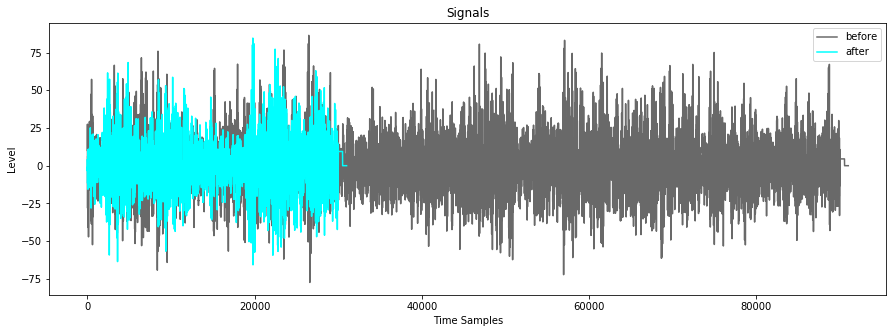

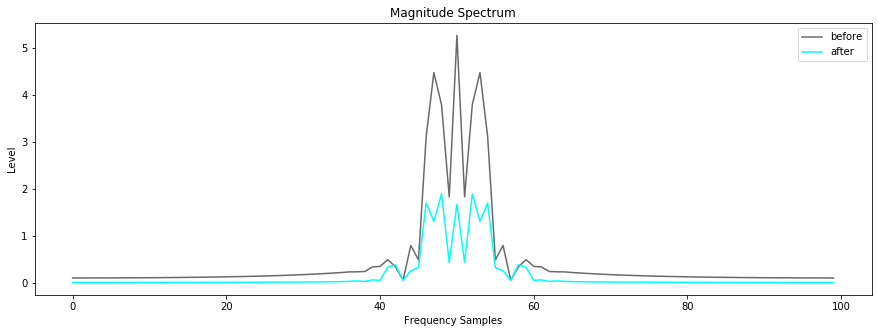

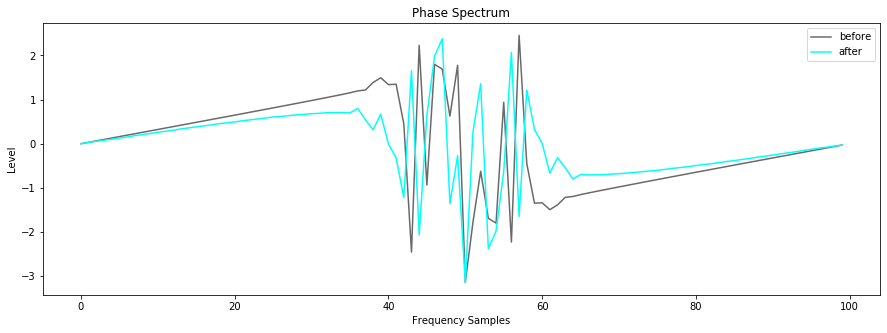

EEG PZ


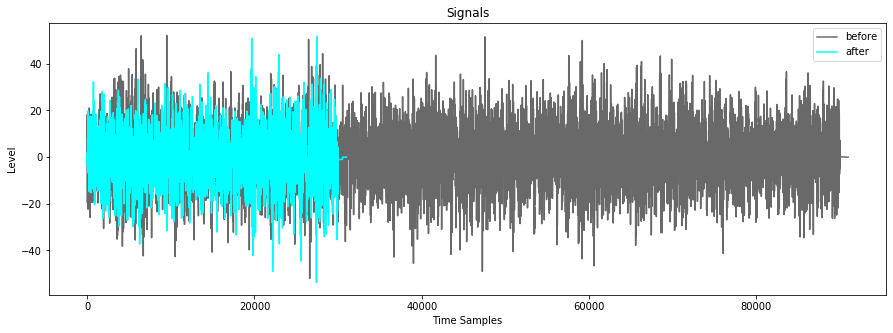

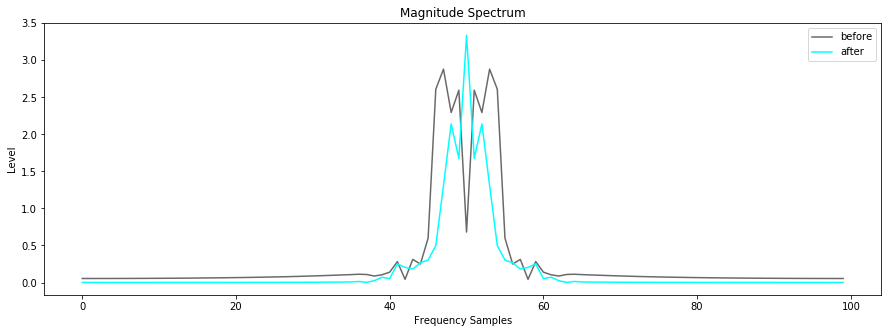

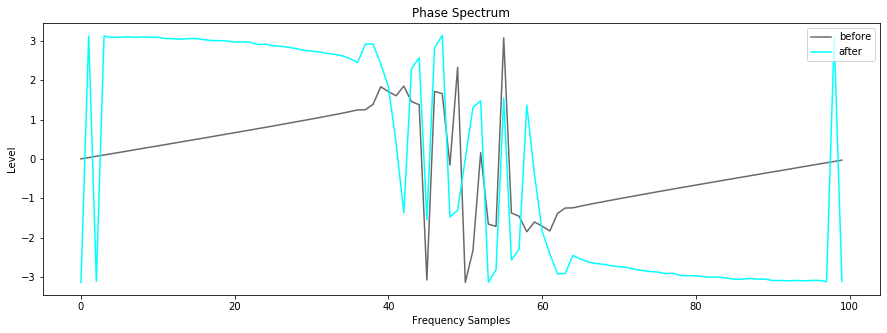

In [15]:
def draw_spactral_analysis(signals_before, signals_after, sample_headers, name, xlabels, ylabels, color_b = '', color_a = ''):
    print(name.upper())
    for signal_b, signal_a, head, xlabel, ylabel in zip(signals_before, signals_after, sample_headers, xlabels, ylabels):
        plt.figure(figsize=(15, 5))
        if len(signal_a)>0:
            plt.plot(signal_b, c=color_b, label = 'before')
        if len(signal_b)>0:
            plt.plot(signal_a, c=color_a, label = 'after')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(head)
        plt.legend(ncol=1)
        plt.show()

color_b = np.random.rand(3,)
color_a = np.random.rand(3,)
for s1, s2, h1, h2 in zip(sample_1, sample_2, sample_headers_1, sample_headers_2):
    magnitude_spectrum1, phase_spectrum1 = spectral_analysis(s1)
    magnitude_spectrum2, phase_spectrum2 = spectral_analysis(s2)
    titles = ['Signals', 'Magnitude Spectrum', 'Phase Spectrum']
    draw_spactral_analysis([s1, magnitude_spectrum1, phase_spectrum1], 
                           [s2, magnitude_spectrum2, phase_spectrum2],
                           ['Signals', 'Magnitude Spectrum', 'Phase Spectrum'], 
                           h1['label'],
                           ['Time Samples', 'Frequency Samples', 'Frequency Samples'],
                           ['Level' for _ in range(3)],
                           'dimgray', 
                           'cyan')


#### Выводы:
- Обнаружено влияние мозговой активности на альфа-ритмы. При высокой активности - депрессия альфа-ритмов.
- Произведен спектральный анализ с применением сглаживающего окна
- С моей точки зрения, возможности использования ЭЭГ для нейроинтерфейсов очень широки. Приведу несколько примеров, где это предположительно могло бы использоваться. 
 - Системы по работе с психоэмоциональными состояниями
 - Тренинги для ментальных способностей
 - Игры
 - Различные аксессуары для людей с ограниченными возможностями способные упростить выполнение каких-либо действий или же вообще позволить их выполнять